## Выполнение практической работы №2 по предмету Система для сбора событий и логов на тему - "Анализ логов"

Выполнил студент - Сидоренков Никита Дмитриевич группы: ББМО-02-23

Вариант задания:

Формула расчета номера варианта задания - №пп % 16 + 1
Список - https://onedrive.live.com/view.aspx?resid=3D84F0F7CD8E489D%2154257&authkey=!AGc4ac7JcMOgGU8

В списке группы - 31
Расчет - 15 % 16 + 1 = 16

В качестве логов по варианту - Zookeeper в репозитории loghub

## 1 - Начинаем с загрузки файлов из репозитория loghub в рабочую область проекта:

In [69]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

## **2 - Перейдем к соданию регулярного выражения для парсинга логов:**

Для примера возьмем строчку из логов `Zookeeper`:

`2015-07-29 19:04:29,071 - WARN  [SendWorker:188978561024:QuorumCnxManager$SendWorker@688] - Send worker leaving thread`

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

`(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})` - Cоответствует дате и времени;

`(\w+)` - Эта часть ищет одно или более словенных символов (буквы, цифры или подчеркивания), которые представляют уровень лога (например, INFO, ERROR);

`\s+` - Отвечает за пробелы в строках;

`\[([^]+)]` - Cоответствует информации о потоке;

`(.*)` - Эта часть ищет любые символы (кроме новой строки), которые представляют сообщение лога.

**Реализация регулярного выражения:**

In [70]:
pattern = r'(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2},\d{3})\s+-\s+(\w+)\s+\[([^]]+)\]\s+-\s+(.*)'

## **3 - Cоздание базы данных для хранения записей полученных логов:**

In [71]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

import sqlite3

# Путь к файлу с БД:
db_path = './db/log-db.db'

# Подключение к БД:
connection = sqlite3.connect(db_path)

# Создание курсора:
cursor = connection.cursor()

# Очистка БД, если таблица уже создана:
cursor.execute("DROP TABLE IF EXISTS logs")

# Создание таблицы:
cursor.execute("CREATE TABLE logs (Id INTEGER PRIMARY KEY AUTOINCREMENT, Datetime TEXT, Msg_type TEXT, Component TEXT, Message TEXT)")

# Сохранение изменений:
connection.commit()

# Закрытие курсора:
cursor.close()

# Закрытие подключения к БД:
connection.close()

## **4 - Перейдем к парсингу логов `Zookeeper` и сохранению полученных данных в БД:**

In [72]:
import sqlite3
import re

# Подключение к БД и создание курсора:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Очистка таблицы для предотвращения дублирования данных:
cursor.execute("DELETE FROM logs")

# Парсинг файла с логами
with open('./loghub/Zookeeper/Zookeeper_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            date = log_match.group(1)
            time = log_match.group(2)
            # Формирование полной даты в формате ISO8601:
            datetime = f"{date} {time}"
            # Уровень логирования:
            msg_type = log_match.group(3)
            component = log_match.group(4)
            message = log_match.group(5)
            # Создание объекта для подстановки в SQL-запрос:
            values = (datetime, msg_type, component, message)
            sql = "INSERT INTO logs (Datetime, Msg_type, Component, Message) VALUES (?, ?, ?, ?)"
            # Запись данных в БД:
            cursor.execute(sql, values)

connection.commit()
cursor.close()
connection.close()

## **5 - Перейдем к чтению данных, записанных ранее в БД:**

In [73]:
import pandas as pd

# подключение к БД и создание курсора:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы:
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame:
log_df = pd.DataFrame(rows, columns=("Id", "DateTime", "LogLevel", "Component", "Message"))
log_df

,Id,DateTime,LogLevel,Component,Message
0,1,"2015-07-29 19:04:12,394",INFO,/10.10.34.11:3888:QuorumCnxManager$Listener@493,Received connection request /10.10.34.11:45307
1,2,"2015-07-29 19:04:29,071",WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
2,3,"2015-07-29 19:04:29,079",WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Interrupted while waiting for message on queue
3,4,"2015-07-29 19:13:17,524",WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
4,5,"2015-07-29 19:13:24,282",WARN,RecvWorker:188978561024:QuorumCnxManager$RecvW...,"Connection broken for id 188978561024, my id =..."
...,...,...,...,...,...
1832,1833,"2015-08-10 17:52:39,698",INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181:ZooK...,Client attempting to establish new session at ...
1833,1834,"2015-08-10 17:53:14,914",INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181:NIOS...,Closed socket connection for client /10.10.34....
1834,1835,"2015-08-10 17:53:16,001",INFO,SessionTracker:ZooKeeperServer@325,"Expiring session 0x14f05578bd80006, timeout of..."
1835,1836,"2015-08-10 18:12:34,001",INFO,SessionTracker:ZooKeeperServer@325,"Expiring session 0x14f05578bd8000f, timeout of..."


## **6 - Перейдем к нормализации полученных данных и записи новой версии в БД:**

### **6.1 - Начнем с нормализации Даты и времени (уберем секунды):**

In [74]:
import sqlite3

# Подключение к базе данных:
db_path = './db/log-db.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Обновление поля Datetime, убирая секунды:
cursor.execute("""
    UPDATE logs
    SET Datetime = substr(Datetime, 1, 19)
""")

# Сохранение изменений и закрытие соединения:
connection.commit()
cursor.close()
connection.close()

#### **6.1.1 - Проверим результат нормализации DateTime:**

In [75]:
# Подключение к базе данных для проверки:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Получение всех записей для проверки:
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

# Закрытие соединения:
cursor.close()
connection.close()

# запись данных в объект DataFrame:
log_df = pd.DataFrame(rows, columns=("Id", "DateTime", "LogLevel", "Component", "Message"))
log_df

,Id,DateTime,LogLevel,Component,Message
0,1,2015-07-29 19:04:12,INFO,/10.10.34.11:3888:QuorumCnxManager$Listener@493,Received connection request /10.10.34.11:45307
1,2,2015-07-29 19:04:29,WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
2,3,2015-07-29 19:04:29,WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Interrupted while waiting for message on queue
3,4,2015-07-29 19:13:17,WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
4,5,2015-07-29 19:13:24,WARN,RecvWorker:188978561024:QuorumCnxManager$RecvW...,"Connection broken for id 188978561024, my id =..."
...,...,...,...,...,...
1832,1833,2015-08-10 17:52:39,INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181:ZooK...,Client attempting to establish new session at ...
1833,1834,2015-08-10 17:53:14,INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181:NIOS...,Closed socket connection for client /10.10.34....
1834,1835,2015-08-10 17:53:16,INFO,SessionTracker:ZooKeeperServer@325,"Expiring session 0x14f05578bd80006, timeout of..."
1835,1836,2015-08-10 18:12:34,INFO,SessionTracker:ZooKeeperServer@325,"Expiring session 0x14f05578bd8000f, timeout of..."


### **6.2 - Отсортируем нашу таблицу по LogLevel и просмотрим результат:**

In [80]:
import sqlite3

# Подключение к базе данных:
db_path = './db/log-db.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Получение всех записей, отсортированных по LogLevel (Msg_type):
cursor.execute("SELECT * FROM logs ORDER BY Msg_type DESC")
sorted_rows = cursor.fetchall()


# Закрытие соединения:
cursor.close()
connection.close()

# запись данных в объект DataFrame:
log_df = pd.DataFrame(sorted_rows, columns=("Id", "DateTime", "LogLevel", "Component", "Message"))
log_df

,Id,DateTime,LogLevel,Component,Message
0,2,2015-07-29 19:04:29,WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
1,3,2015-07-29 19:04:29,WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Interrupted while waiting for message on queue
2,4,2015-07-29 19:13:17,WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
3,5,2015-07-29 19:13:24,WARN,RecvWorker:188978561024:QuorumCnxManager$RecvW...,"Connection broken for id 188978561024, my id =..."
4,7,2015-07-29 19:13:27,WARN,RecvWorker:188978561024:QuorumCnxManager$RecvW...,"Connection broken for id 188978561024, my id =..."
...,...,...,...,...,...
1832,636,2015-07-29 19:20:16,ERROR,LearnerHandler-/10.10.34.12:59455:LearnerHandl...,Unexpected exception causing shutdown while so...
1833,638,2015-07-29 19:20:36,ERROR,LearnerHandler-/10.10.34.12:59480:LearnerHandl...,Unexpected exception causing shutdown while so...
1834,639,2015-07-29 19:20:46,ERROR,LearnerHandler-/10.10.34.13:57617:LearnerHandl...,Unexpected exception causing shutdown while so...
1835,640,2015-07-29 19:20:56,ERROR,LearnerHandler-/10.10.34.11:52814:LearnerHandl...,Unexpected exception causing shutdown while so...


## **7 - Начнем осуществление статистического анализа и визуализации результатов:**

### **7.1 - Осуществим статистический анализ DateTime и отобразим его визуализацию:**

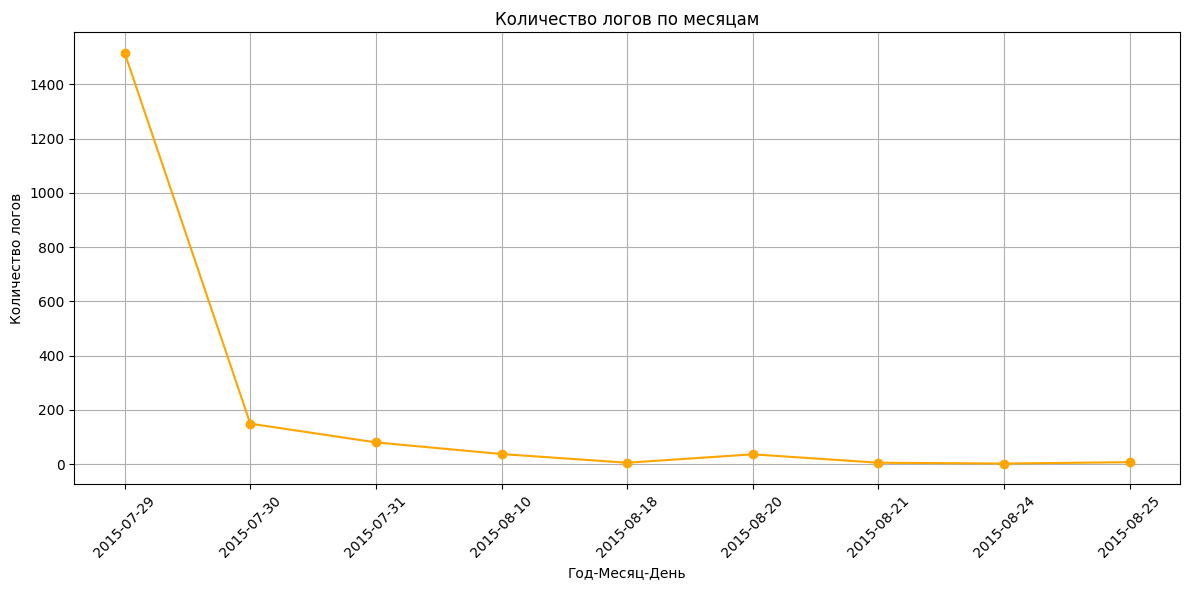

In [81]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Подключение к базе данных и загрузка данных:
conn = sqlite3.connect('/content/db/log-db.db')
df = pd.read_sql_query("SELECT * FROM logs", conn)

# Преобразование столбца Datetime в формат datetime:
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Извлечение года и месяца:
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day

# Подсчет количества логов по годам и месяцам:
monthly_log_counts = df.groupby(['Year', 'Month', 'Day']).size().reset_index(name='LogCount')

# Создание столбца для отображения даты в формате "YYYY-MM-DD":
monthly_log_counts['YearMonthDay'] = monthly_log_counts['Year'].astype(str) + '-' + monthly_log_counts['Month'].astype(str).str.zfill(2) + '-' + monthly_log_counts['Day'].astype(str).str.zfill(2)

# Визуализация количества логов по месяцам:
plt.figure(figsize=(12, 6))
plt.plot(monthly_log_counts['YearMonthDay'], monthly_log_counts['LogCount'], marker='o', color='orange')
plt.title('Количество логов по месяцам')
plt.xlabel('Год-Месяц-День')
plt.ylabel('Количество логов')
plt.xticks(rotation=45)
plt.grid()

# Показать график:
plt.tight_layout()
plt.show()

### **7.2 - Осуществим статистический анализ LogLevel и визуализируем полученный результат:**

Msg_type
WARN     1232
INFO      592
ERROR      13
Name: count, dtype: int64


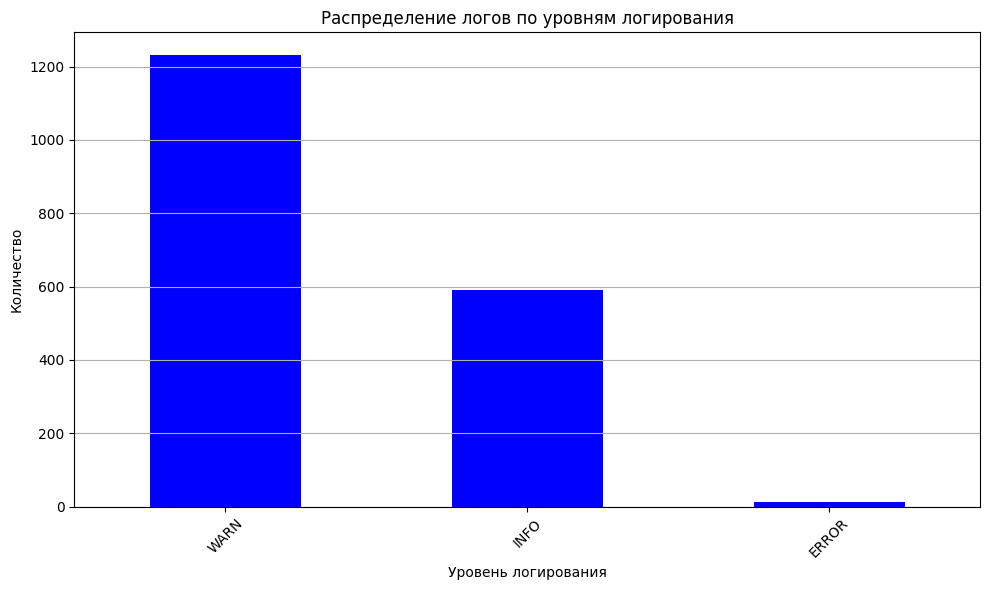

In [78]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Подключение к базе данных и загрузка данных:
conn = sqlite3.connect('/content/db/log-db.db')
df = pd.read_sql_query("SELECT * FROM logs", conn)

# Подсчет количества логов по уровням логирования:
log_counts = df['Msg_type'].value_counts()
print(log_counts)

# Визуализация количества логов по уровням логирования:
plt.figure(figsize=(10, 6))
log_counts.plot(kind='bar', color='blue')
plt.title('Распределение логов по уровням логирования')
plt.xlabel('Уровень логирования')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Показать график:
plt.tight_layout()
plt.show()

In [79]:
# Разорвем соединение с БД:
conn.close()